Libraries import

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile

Tensor product definition

In [2]:

def tensor_product(arr):
    M = np.kron(arr[0], arr[1])
    for i in range(2, len(arr)):
        M = np.kron(M, arr[i])
    return M

Quantum operators definition

In [3]:
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1.j], [1.j, 0]])
Z = np.array([[1, 0], [0, -1]])
U = I + X + Y + Z

Definition of Kraus operator for phaseflip error

In [4]:
p = 0.8

K0 = np.sqrt(1 - p) * tensor_product([I, I, I]) 
K1 = np.sqrt(p/3)*tensor_product([Z, I, I])
K2 = np.sqrt(p/3)*tensor_product([I, Z, I])
K3 = np.sqrt(p/3)*tensor_product([I, I, Z])
phaseflip_one_error = Kraus([K0, K1, K2, K3])

Circuit creation and drawing

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


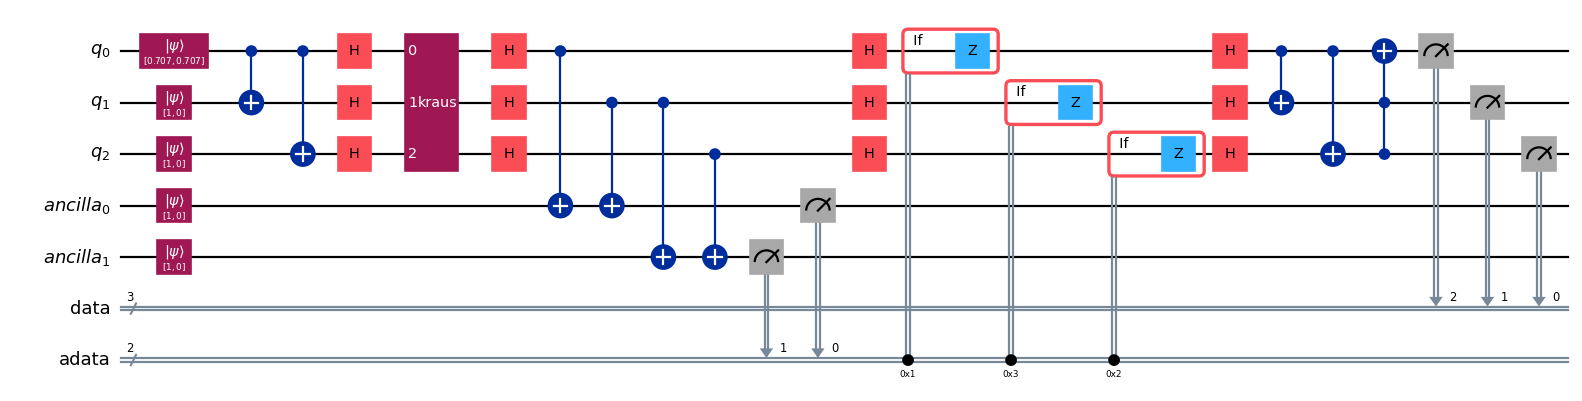

In [7]:
qreg = QuantumRegister(3, 'q')
qreg2 = QuantumRegister(2, 'ancilla')
creg1 = ClassicalRegister(3, 'data')
creg2 = ClassicalRegister(2, 'adata')

qcirc = QuantumCircuit(qreg, qreg2, creg1, creg2)
qcirc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0) #prepare state in superposition
qcirc.initialize([1, 0], 1)
qcirc.initialize([1, 0], 2)
qcirc.initialize([1, 0], 3)
qcirc.initialize([1, 0], 4)

qcirc.cx(0,1)
qcirc.cx(0,2)
qcirc.h([0,1,2])
qcirc.append(phaseflip_one_error, [0, 1, 2])
qcirc.h([0,1,2])

qcirc.cx(0, 3)
qcirc.cx(1, 3)
qcirc.cx(1, 4)
qcirc.cx(2, 4)
qcirc.barrier(range(4))

qcirc.measure(3, creg2[0])
qcirc.measure(4, creg2[1])
qcirc.barrier(range(3))

qcirc.h([0,1,2])

with qcirc.if_test((creg2, 1)):
    qcirc.z(0)
with qcirc.if_test((creg2, 3)):
    qcirc.z(1)
with qcirc.if_test((creg2, 2)):
    qcirc.z(2)

qcirc.barrier(range(3))

qcirc.h([0,1,2])
qcirc.cx(0,1)
qcirc.cx(0,2)
qcirc.ccx(1, 2, 0)


qcirc.measure([0, 1, 2], [2, 1, 0])

qcirc.draw("mpl", scale=0.8, fold=-1, plot_barriers=False)

Simulation and plotting results

{'000': 505, '100': 519}


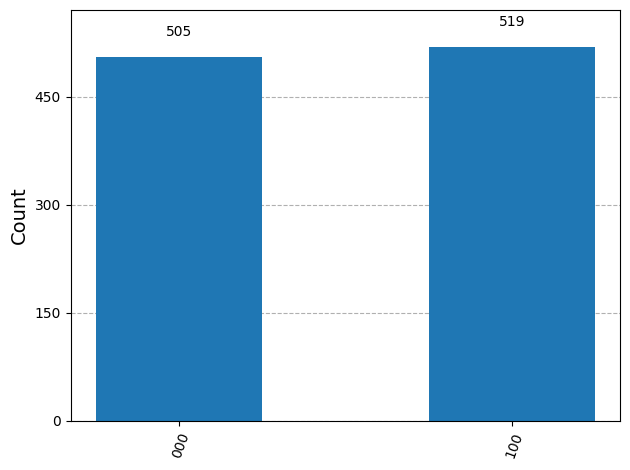

In [8]:
simulator = AerSimulator(method='density_matrix')
tqc = transpile(qcirc, simulator)
result = simulator.run(tqc, shots=1024).result()
from qiskit.result import marginal_counts

# Get counts and plot
counts = result.get_counts(tqc)

data_counts = marginal_counts(counts, indices=[0,1,2])

print(data_counts)
plot_histogram(data_counts)